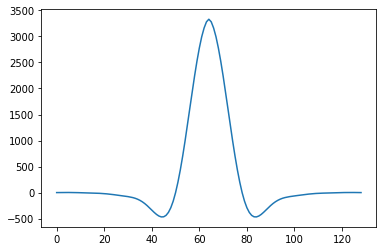

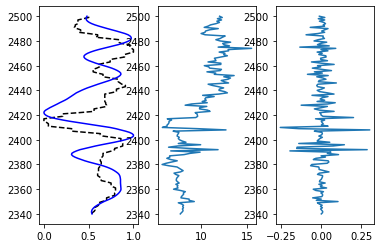

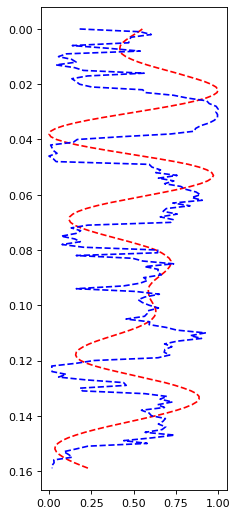

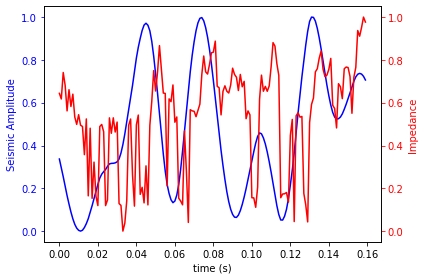

Training examples: 750
Validation examples: 275
Test examples: 275
Example shape: (160, 1)


In [1]:
%run ./01v_volve_generate_data.ipynb

import tensorflow as tf
import keras
from keras import layers
from keras import backend as K
#import src

from skimage import feature
from skimage.filters import gaussian

import scipy.stats as stats
import math

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
# expected input data shape: (batch_size, timesteps, data_dim)

num_features = 1
num_hidden_units1 = 120

num_hidden_units2 = 150
num_responses = 1
max_epochs = 500
mini_batch_size = 5

lstm_net = keras.models.Sequential([
    layers.Bidirectional(
        layers.LSTM(units=num_hidden_units1, return_sequences=True
    ), input_shape=(160,1)),
    layers.BatchNormalization(epsilon=1e-4),
    layers.ReLU(),
    layers.Dense(150),
    layers.Dense(50),
    layers.Bidirectional(
        layers.LSTM(units=num_hidden_units2, return_sequences=True)
    ),
    layers.Dense(num_responses)
])

lstm_net.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 160, 240)          117120    
_________________________________________________________________
batch_normalization (BatchNo (None, 160, 240)          960       
_________________________________________________________________
re_lu (ReLU)                 (None, 160, 240)          0         
_________________________________________________________________
dense (Dense)                (None, 160, 150)          36150     
_________________________________________________________________
dense_1 (Dense)              (None, 160, 50)           7550      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 160, 300)          241200    
_________________________________________________________________
dense_2 (Dense)              (None, 160, 1)            3

In [4]:
def scheduler(epoch, lr):
    if epoch % 150 == 0 and epoch != 0:
        value = lr * tf.math.exp(-0.1)
        K.set_value(lstm_net.optimizer.lr, value)
        return K.get_value(lstm_net.optimizer.lr)
    else:
        return K.get_value(lstm_net.optimizer.lr)
    
callback =  tf.keras.callbacks.EarlyStopping(monitor='loss', 
                                             mode='min',
                                             restore_best_weights=True,
                                             verbose=2,
                                             patience=300)
    
lr_scheduler = keras.callbacks.LearningRateScheduler(scheduler, verbose=1)

optimizer = keras.optimizers.Adam(learning_rate=0.001, clipnorm=2)

loss_metrics = [
    'mse',
    'mae'
]

metric_funcs = [
    tf.keras.metrics.MeanSquaredError(),
    tf.keras.metrics.MeanAbsoluteError(),
    tf.keras.metrics.RootMeanSquaredError()
]

lstm_net.compile(optimizer=optimizer,
                 loss=loss_metrics,
                 metrics=metric_funcs)

history_lstm = lstm_net.fit(trainX,
                            trainIp,
                            shuffle=False,
                            batch_size=mini_batch_size,
                            epochs=max_epochs,
             #               callbacks=[lr_scheduler],
                            callbacks=callback,
                            validation_data=(x_valid, y_valid),
                            validation_freq=1)

Epoch 1/500
150/150 [==============================] - 12s 44ms/step - loss: 0.0978 - mean_squared_error: 0.0978 - mean_absolute_error: 0.2248 - root_mean_squared_error: 0.2971 - val_loss: 0.1495 - val_mean_squared_error: 0.1495 - val_mean_absolute_error: 0.3356 - val_root_mean_squared_error: 0.3867
Epoch 2/500
150/150 [==============================] - 4s 29ms/step - loss: 0.0341 - mean_squared_error: 0.0341 - mean_absolute_error: 0.1454 - root_mean_squared_error: 0.1846 - val_loss: 0.1259 - val_mean_squared_error: 0.1259 - val_mean_absolute_error: 0.3136 - val_root_mean_squared_error: 0.3548
Epoch 3/500
150/150 [==============================] - 4s 29ms/step - loss: 0.0322 - mean_squared_error: 0.0322 - mean_absolute_error: 0.1409 - root_mean_squared_error: 0.1794 - val_loss: 0.0870 - val_mean_squared_error: 0.0870 - val_mean_absolute_error: 0.2671 - val_root_mean_squared_error: 0.2949
Epoch 4/500
150/150 [==============================] - 4s 29ms/step - loss: 0.0295 - mean_squared_e

9/9 [==============================] - 1s 13ms/step
(275, 160, 1)


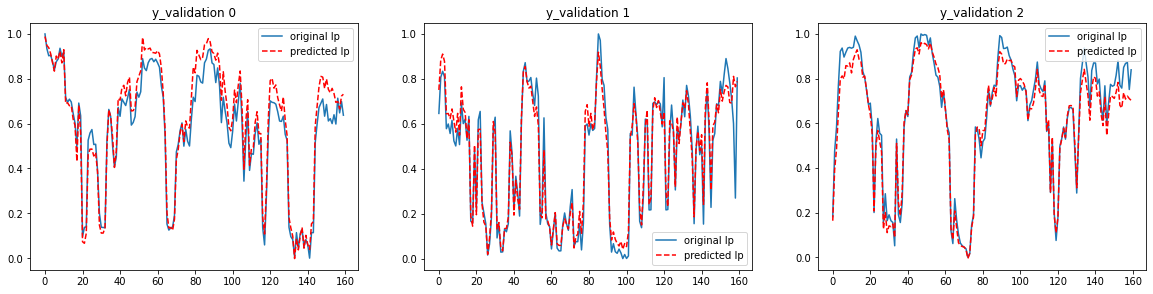

In [5]:
y_predicted = lstm_net.predict(x_test, verbose=1)
print(x_test.shape)

n = 3
plt.figure(figsize=(20, 10))
for i in range(1, n + 1):
    ax = plt.subplot(2, n, i)
    ax.set_title("y_validation {0}".format(i-1))
    plt.plot(y_test[i-1, :, 0])
    plt.plot(y_predicted[i-1, :, 0], '--r')
    plt.legend(['original Ip', 'predicted Ip'])
plt.show()

SSIM:  0.9545735
SSIM Multiscale:  0.9697747


Text(0.5, 1.0, 'Target')

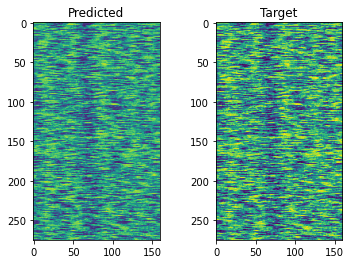

In [6]:
# ypredicted_f32 = tf.cast(y_predicted, dtype=tf.float32)
# ytest_f32 = tf.cast(y_test, dtype=tf.float32)

# result = tf.image.ssim(ytest_f32, ypredicted_f32, max_val=1)

# print(result)
predict_image = y_predicted.flatten()
predict_image = (predict_image-np.min(predict_image))/(np.max(predict_image)-np.min(predict_image))
predict_image = predict_image.reshape(y_predicted.shape)
predict_image = (predict_image).astype('float32')

target_image = y_test.flatten()
target_image = (target_image-np.min(target_image))/(np.max(target_image)-np.min(target_image))
target_image = target_image.reshape(y_test.shape)
target_image = target_image.astype('float32')

SSIM = tf.image.ssim(target_image, predict_image, max_val=1).numpy()
MSSIM = tf.image.ssim_multiscale(target_image, predict_image, max_val=1, power_factors=(0.0448, 0.2856, 0.3001, 0.2363)).numpy()
print('SSIM: ', SSIM)
print('SSIM Multiscale: ', MSSIM)

fig1, axes1 = plt.subplots(nrows=1, ncols=2)
axes1[0].imshow(predict_image[:,:,0])
axes1[0].set_title("Predicted")
axes1[1].imshow(target_image[:,:,0])
axes1[1].set_title("Target")

In [7]:
# print("RESULTS TRAINING:")
# print(f"Loss: {history_lstm.history['loss'][-1]}")
# print(f"Mean Squared Error (MSE): {history_lstm.history['mean_squared_error'][-1]}")
# print(f"Mean Absolute Error (MAE): {history_lstm.history['mean_absolute_error'][-1]}")
# print(f"Root Mean Squared Error: {history_lstm.history['root_mean_squared_error'][-1]}")

# print("\nRESULTS VALIDATION:")
# print(f"Loss: {history_lstm.history['val_loss'][-1]}")
# print(f"Mean Squared Error (MSE): {history_lstm.history['val_mean_squared_error'][-1]}")
# print(f"Mean Absolute Error (MAE): {history_lstm.history['val_mean_absolute_error'][-1]}")
# print(f"Root Mean Squared Error: {history_lstm.history['val_root_mean_squared_error'][-1]}")

mse_res = tf.keras.metrics.mean_squared_error(target_image.flatten(), predict_image.flatten()).numpy()
mae_res = tf.keras.metrics.mean_absolute_error(target_image.flatten(), predict_image.flatten()).numpy()

m = tf.keras.metrics.RootMeanSquaredError()
m.update_state(target_image.flatten(), predict_image.flatten())

print(f"MSE: ", mse_res)
print("MAE: ", mae_res)
print("RMSE: ", m.result().numpy())

MSE:  0.006192498
MAE:  0.06345012
RMSE:  0.07869243


In [8]:
def soft_F_measure(target_data,
                   predicted_data,
                   canny_sigma=3,
                   gaussian_sigma=1,
                   beta_F1=1,
                   plot_data=True):
    e = feature.canny(target_data, sigma=canny_sigma)
    e_ = feature.canny(predicted_data, sigma=canny_sigma)

    e_ = gaussian(e_,sigma=gaussian_sigma,multichannel=None, preserve_range=True)
    #e_ = e_/np.max(e_.flatten())-np.min(e_.flatten())

    TP = np.minimum(e,e_)
    TN = np.minimum(1-e,1-e_)
    FP = np.maximum(e_ - e , np.zeros(e.shape))
    FN = np.maximum(e - e_ , np.zeros(e.shape))
    sTP = np.sum(TP.flatten())
    sTN = np.sum(TN.flatten())
    sFP = np.sum(FP.flatten())
    sFN = np.sum(FN.flatten())
    
    soft_precision = sTP/(sTP+sFP)
    soft_recall = sTP/(sTP+sFN)
    
    soft_FM = (1+beta_F1**2)*(soft_precision*soft_recall)/(soft_precision*(beta_F1**2)+soft_recall)
    if plot_data:
    
        fig, ax = plt.subplots(nrows=2, ncols=4,figsize=(16, 8))
        ax[0,0].imshow(target_data)
        ax[0,0].set_title('ground truth')

        ax[1,0].imshow(e, cmap='gray')
        ax[1,0].set_title('ground truth, canny, sigma:{}'.format(canny_sigma))

        ax[0,1].imshow(predicted_data)
        ax[0,1].set_title('predicted')

        ax[1,1].imshow(e_, cmap='gray')
        ax[1,1].set_title('predicted, canny, sigma:{}'.format(canny_sigma))
        
        ax[0,2].imshow(TP)
        ax[0,2].set_title('True Positive')

        ax[1,2].imshow(TN)
        ax[1,2].set_title('True Negative')

        ax[0,3].imshow(FP)
        ax[0,3].set_title('False Positive'.format(canny_sigma))

        ax[1,3].imshow(FN)
        ax[1,3].set_title('False Negative'.format(canny_sigma))

        fig.tight_layout()
        plt.show()
        
    return soft_FM

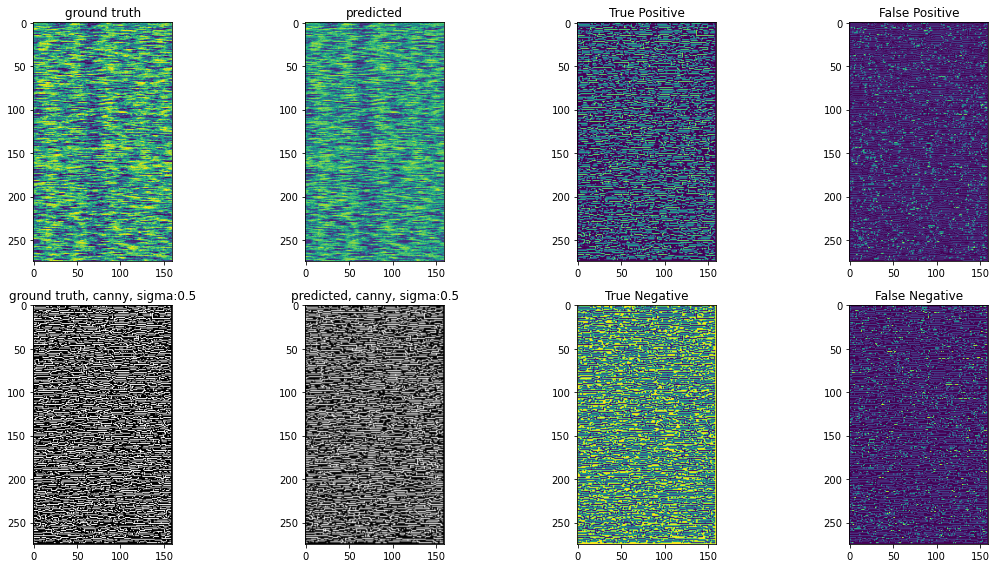

0.6719532794911551


In [9]:
Fb = soft_F_measure(target_data=target_image[:,:,0],
                    predicted_data=predict_image[:,:,0],                 
                    canny_sigma=0.5,
                    gaussian_sigma=0.5,
                    beta_F1=1,
                    plot_data=True)

print(Fb)